In [140]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.vector_ar.var_model import VAR
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [141]:
cd C:\Users\Iulia\Desktop\CreditRisk

C:\Users\Iulia\Desktop\CreditRisk


In [142]:
data = pd.read_csv('DTSE_AIS_unemployment_task_data.csv')

### Exploratory Data Analysis (EDA)

In [143]:
# calculate the percentage of missing values in each column
# missing_percentages = df.isna().mean() * 100
missing_percentages = data.isin([np.nan]).mean() * 100
# sort the columns by percentage of missing values, descending
sorted_missing_percentages = missing_percentages.sort_values(ascending=False)
# select the top columns with missing values (adjust the number as needed)
top_missing_percentages = round(sorted_missing_percentages,4).head(15)
# print the top columns with their percentage of missing values
print(top_missing_percentages)

data.interpolate(method='linear', inplace=True)

unemp      0.4926
Period     0.0000
realgdp    0.0000
pop        0.0000
infl       0.0000
dtype: float64


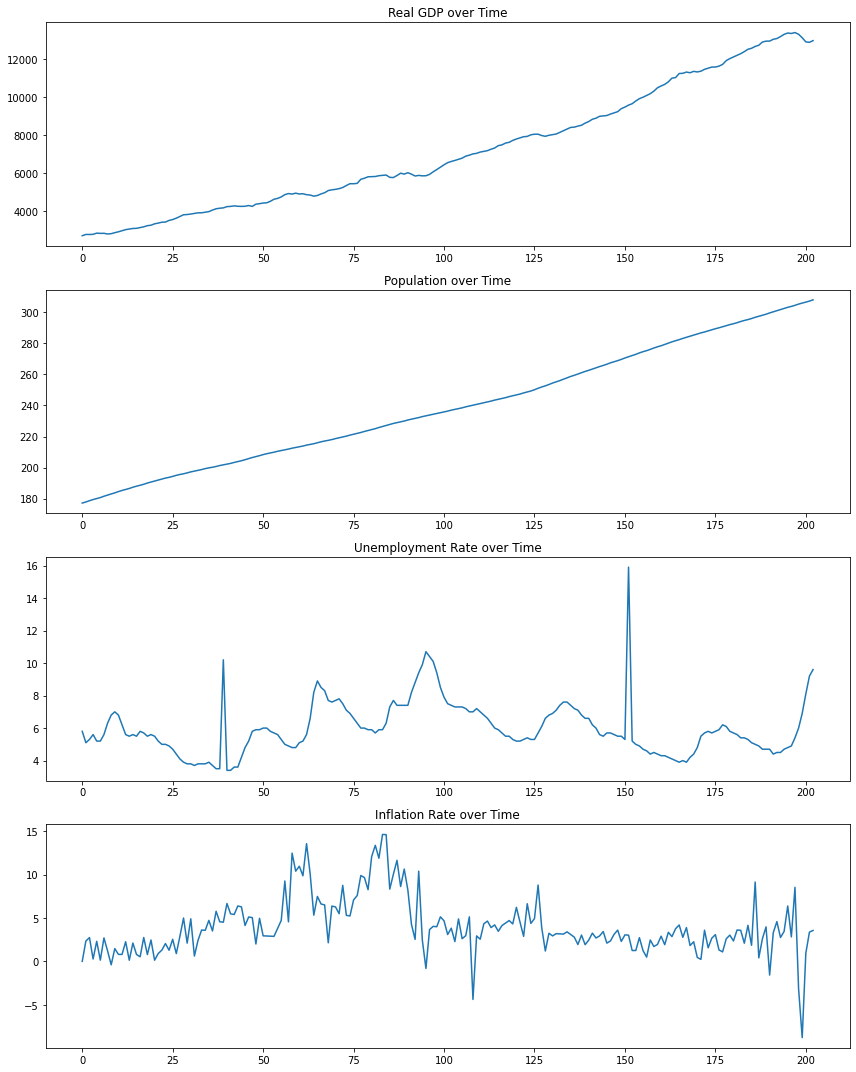

In [144]:
# Plotting each column to see the trend over time
fig, ax = plt.subplots(4, 1, figsize=(12, 15))

data['realgdp'].plot(ax=ax[0], title='Real GDP over Time')
data['pop'].plot(ax=ax[1], title='Population over Time')
data['unemp'].plot(ax=ax[2], title='Unemployment Rate over Time')
data['infl'].plot(ax=ax[3], title='Inflation Rate over Time')

plt.tight_layout()
plt.show()

### Correlation Analysis:

In [145]:
correlation_matrix = data.corr()
print(correlation_matrix['unemp'])

realgdp   -0.053140
pop        0.014220
unemp      1.000000
infl       0.052153
Name: unemp, dtype: float64


### Model Building

In [56]:
# Selecting our predictors
X = data[['realgdp', 'pop', 'infl']]
y = data['unemp']

# Splitting our data for testing and training. Here, we'll use the last 20 points for testing.
X_train, X_test = X[:-20], X[-20:]
y_train, y_test = y[:-20], y[-20:]

lr = LinearRegression()
lr.fit(X_train, y_train)

predictions_lr = lr.predict(X_test)
mse_lr = mean_squared_error(y_test, predictions_lr)
print(f'Linear Regression MSE: {mse_lr}')

Linear Regression MSE: 5.0877974330891425


In [57]:
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train, y_train)

predictions_rf = rf.predict(X_test)
mse_rf = mean_squared_error(y_test, predictions_rf)
print(f'Random Forest MSE: {mse_rf}')

Random Forest MSE: 2.310555200000002


In [58]:
# Assuming our forecasted unemployment rate for 2013 is 'unemp_2013'
unemp_2013 = predictions_rf[-4:].mean()

# Using the 65% labor force participation rate to compute the number of unemployed individuals
pop_2013 = data['pop'].iloc[-1]  # Using the last known population data as an estimate
labor_force = pop_2013 * 0.65
unemployed_people = labor_force * (unemp_2013 / 100)
print(f'Estimated number of unemployed people in 2013: {unemployed_people:.2f} million')

Estimated number of unemployed people in 2013: 11.32 million


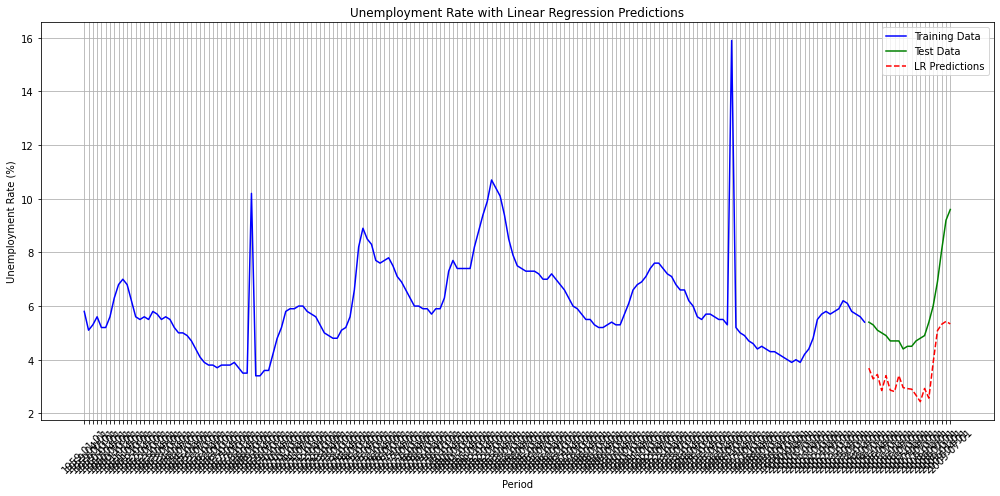

In [59]:
# Plotting the original data
plt.figure(figsize=(14, 7))

# Original Data: Training and Test
plt.plot(data['Period'][:-20], y_train, color='blue', label='Training Data')
plt.plot(data['Period'][-20:], y_test, color='green', label='Test Data')

# Linear Regression Predictions
plt.plot(data['Period'][-20:], predictions_lr, color='red', linestyle='--', label='LR Predictions')

# Formatting the plot
plt.title('Unemployment Rate with Linear Regression Predictions')
plt.xlabel('Period')
plt.ylabel('Unemployment Rate (%)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

Ensemble MSE: 2.3868445085707948


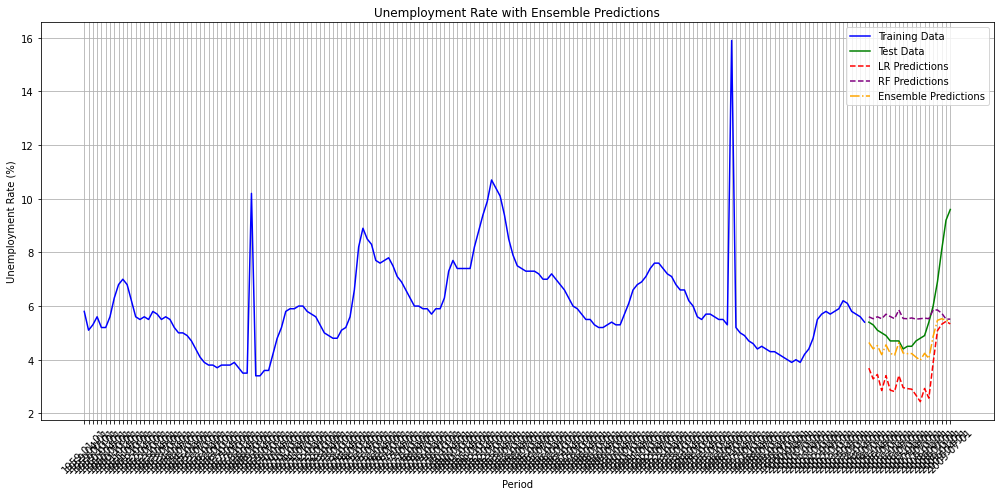

In [60]:
# Combine the predictions from both models (ensemble)
ensemble_predictions = (predictions_lr + predictions_rf) / 2

# Calculate MSE for the ensemble
mse_ensemble = mean_squared_error(y_test, ensemble_predictions)
print(f'Ensemble MSE: {mse_ensemble}')

# Visualization
plt.figure(figsize=(14, 7))

# Original Data: Training and Test
plt.plot(data['Period'][:-20], y_train, color='blue', label='Training Data')
plt.plot(data['Period'][-20:], y_test, color='green', label='Test Data')

# Linear Regression and Random Forest Predictions
plt.plot(data['Period'][-20:], predictions_lr, color='red', linestyle='--', label='LR Predictions')
plt.plot(data['Period'][-20:], predictions_rf, color='purple', linestyle='--', label='RF Predictions')

# Ensemble Predictions
plt.plot(data['Period'][-20:], ensemble_predictions, color='orange', linestyle='-.', label='Ensemble Predictions')

# Formatting the plot
plt.title('Unemployment Rate with Ensemble Predictions')
plt.xlabel('Period')
plt.ylabel('Unemployment Rate (%)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

In [61]:
# Ensure the 'Period' column is in datetime format
data['Period'] = pd.to_datetime(data['Period'])

# Define a function to fit ARIMA and forecast the next 12 quarters
def forecast_arima(series):
    model = ARIMA(series, order=(2, 0, 1))
    results = model.fit()
    forecast = results.forecast(steps=12)
    return forecast


# Forecast each variable
realgdp_forecast = forecast_arima(data['realgdp'])
pop_forecast = forecast_arima(data['pop'])
infl_forecast = forecast_arima(data['infl'])

# Append these forecasts to the original dataframe
forecasted_data = pd.DataFrame({
    'realgdp': realgdp_forecast,
    'pop': pop_forecast,
    'infl': infl_forecast
})

data = pd.concat([data, forecasted_data], ignore_index=True)

# Get the last date from the 'Period' column
last_date = data['Period'].dropna().iloc[-1]  # Drop NaT and get the last available date

# Generate a new date list for the next 12 quarters (3 months = 1 quarter)
new_dates = [(last_date + pd.DateOffset(months=3*x)) for x in range(1, 18)]

# Assign these new dates to the NaN values in the 'Period' column for the forecasted rows
data['Period'].iloc[-17:] = new_dates

print(data.tail(15))

C:\Users\Iulia\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


        Period       realgdp         pop  unemp      infl
200 2010-04-01  12925.410000  306.547000    8.1  0.940000
201 2010-07-01  12901.504000  307.226000    9.2  3.370000
202 2010-10-01  12990.341000  308.013000    9.6  3.560000
203 2011-01-01  12971.298834  308.702902    NaN  2.248495
204 2011-04-01  12952.253280  308.464874    NaN  2.416323
205 2011-07-01  12933.208358  308.537399    NaN  2.503148
206 2011-10-01  12914.167845  308.505991    NaN  2.587383
207 2012-01-01  12895.135291  308.509366    NaN  2.665575
208 2012-04-01  12876.114029  308.501101    NaN  2.738327
209 2012-07-01  12857.107188  308.496733    NaN  2.806008
210 2012-10-01  12838.117708  308.491061    NaN  2.868973
211 2013-01-01  12819.148344  308.485826    NaN  2.927550
212 2013-04-01  12800.201684  308.480445    NaN  2.982046
213 2013-07-01  12781.280155  308.475114    NaN  3.032743
214 2013-10-01  12762.386031  308.469766    NaN  3.079907


C:\Users\Iulia\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Iulia\AppData\Local\Temp\ipykernel_15808\3631605388.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Period'].iloc[-17:] = new_dates


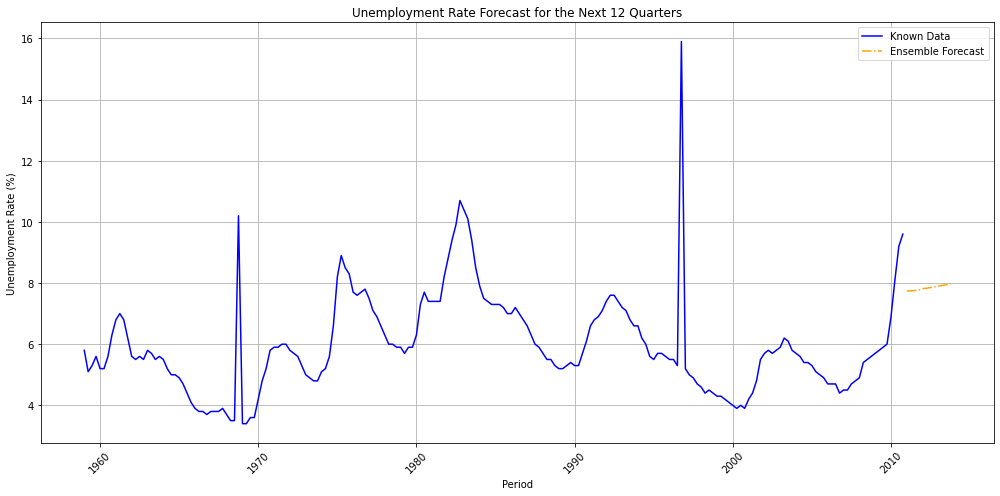

In [69]:
# Assuming you have loaded your data into a DataFrame named data

# Convert 'Period' column to datetime
data['Period'] = pd.to_datetime(data['Period'])

# Split data into predictors X and target variable y
X = data[['realgdp', 'pop', 'infl']]
y = data['unemp']

# Drop the rows with NaN values in the target for training
X_train = X[:-12]  # using data until the last known unemployment value
y_train = y.dropna()

# Train the linear regression and random forest models
lr = LinearRegression().fit(X_train, y_train)
rf = RandomForestRegressor().fit(X_train, y_train)

# Prepare the Future Data using the last known values for the predictors for the next 12 quarters
# future_data = pd.DataFrame({
#     'realgdp': [X['realgdp'].iloc[-1]]*12,
#     'pop': [X['pop'].iloc[-1]]*12,
#     'infl': [X['infl'].iloc[-1]]*12
# })

future_data = data.tail(12).drop(['unemp','Period'], axis=1)

# Predict Using Both Models
future_predictions_lr = lr.predict(future_data)
future_predictions_rf = rf.predict(future_data)

# Ensemble the Predictions
future_ensemble_predictions = (future_predictions_lr + future_predictions_rf) / 2

# Visualize the Predictions
plt.figure(figsize=(14, 7))

# Plotting the known data
plt.plot(data['Period'], y, color='blue', label='Known Data')

# Plotting the ensemble forecast
future_periods = [data['Period'].iloc[-13] + pd.DateOffset(months=3*i) for i in range(1, 13)]
plt.plot(future_periods, future_ensemble_predictions, color='orange', linestyle='-.', label='Ensemble Forecast')

# Formatting the plot
plt.title('Unemployment Rate Forecast for the Next 12 Quarters')
plt.xlabel('Period')
plt.ylabel('Unemployment Rate (%)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

### Varma and Sarima Ensemble

In [146]:
data['Period'] = pd.to_datetime(data['Period'])
data.set_index('Period', inplace=True)
data.sort_index(inplace=True)

In [147]:
train_data = data[:'2009-07-01']
forecast_period = pd.date_range(start='2009-10-01', end='2013-10-01', freq='Q')

In [105]:
from statsmodels.tsa.statespace.varmax import VARMAX

p = 2  # Choose an appropriate order based on model selection criteria.
q = 1

model_varmax = VARMAX(train_data[['unemp', 'realgdp', 'pop', 'infl']], order=(p, q))
results_varmax = model_varmax.fit()

C:\Users\Iulia\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
C:\Users\Iulia\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\Iulia\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Iulia\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Ch

In [106]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

p = 1
d = 1
q = 1
s = 4  # Seasonal order

model_sarima = SARIMAX(train_data['unemp'], order=(p, d, q), seasonal_order=(P, D, Q, s))
results_sarima = model_sarima.fit()

C:\Users\Iulia\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\Iulia\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


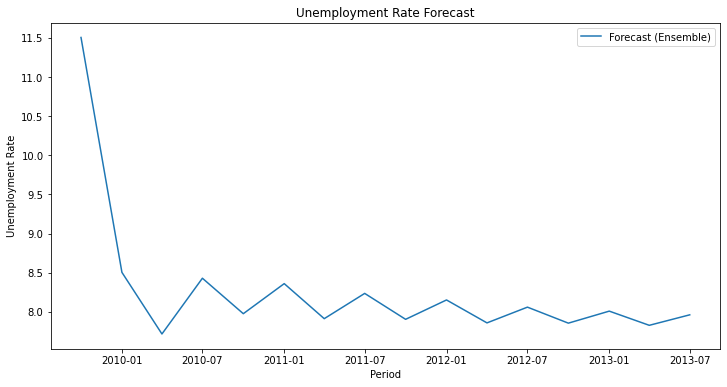

In [150]:
# Ensemble Forecasting (corrected)
forecast_varmax = results_varmax.get_forecast(steps=len(forecast_period))
forecast_varmax_mean = forecast_varmax.predicted_mean.unemp

forecast_sarima = results_sarima.get_forecast(steps=len(forecast_period))
forecast_sarima_mean = forecast_sarima.predicted_mean

weight_varmax = 0.5  # Adjust the weights as needed
weight_sarima = 0.5
final_forecast = weight_varmax * forecast_varmax_mean + weight_sarima * forecast_sarima_mean

# Create a DataFrame with the correct index
forecast_df = pd.DataFrame(final_forecast, index=final_forecast.index, columns=['unemp_forecast'])

# Visualize the Forecast
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(forecast_df.index, forecast_df['unemp_forecast'], label='Forecast (Ensemble)')
plt.legend()
plt.title('Unemployment Rate Forecast')
plt.xlabel('Period')
plt.ylabel('Unemployment Rate')
plt.show()

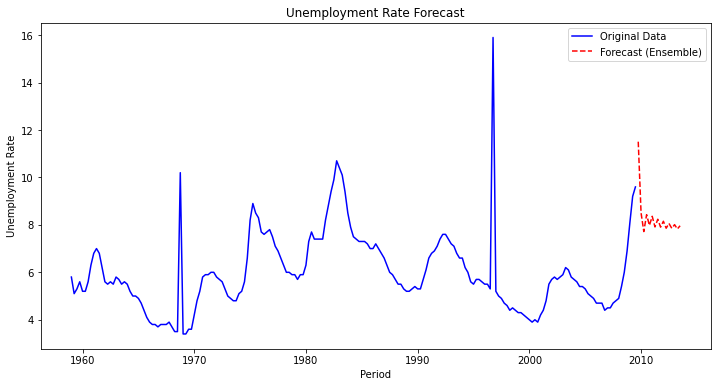

In [151]:
# Create a DataFrame with the correct index for data
data_index = data.index

# Visualize the Forecast alongside the original data
plt.figure(figsize=(12, 6))
plt.plot(data_index, data['unemp'], label='Original Data', color='blue')
plt.plot(forecast_df.index, forecast_df['unemp_forecast'], label='Forecast (Ensemble)', linestyle='--', color='red')
plt.legend()
plt.title('Unemployment Rate Forecast')
plt.xlabel('Period')
plt.ylabel('Unemployment Rate')
plt.show()